In [1]:
import networkx as nx
from matsimAI.flowsim_dataset import FlowSimDataset
import matplotlib.colors as mcolors
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
import os
import torch
import matplotlib.gridspec as gridspec


In [2]:
results_path = Path("/home/isaacp/repos/MatsimAI/cluster_results/results/0428162326_nclusters_10_utahnetwork")
matsim_output = Path("/home/isaacp/repos/MatsimAI/outputs/output_10c")
scenario_path = Path("/home/isaacp/repos/MatsimAI/scenarios/cluster_scenarios/utah_10c")

last_iter = sorted([int(s.split(".")[1]) for s in os.listdir(matsim_output / "ITERS")])[-1]
last_iteration_path = Path(matsim_output, "ITERS", f"it.{last_iter}")
dataset = FlowSimDataset(results_path.parent, Path(scenario_path, "utahnetwork.xml"),  Path(scenario_path, "utahcounts.xml"), 10)
target_graph = dataset.target_graph
sensor_idxs = dataset.sensor_idxs

In [3]:
flows = torch.load(results_path / "best_flows.pt")
OD = flows["OD"].to("cpu")
link_flows = flows["LinkFlows"].to("cpu")
target_flows = target_graph.edge_attr

/tmp/ipykernel_2828454/2012471147.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  flows = torch.load(results_path / "best_flows.pt")


[0.799, 0.967, 0.925, 0.905, 0.667, 0.744, 0.767, 0.972, 0.821, 0.996, 0.991, 0.661, 0.312, 0.608, 0.731, 0.151, 0.777, 0.905, 0.429, 0.357, 0.207, 0.992, 0.032, 0.16, 0.383, 0.978, 0.578, 0.961, 0.558, 0.968, 0.409, 0.91, 0.998, 0.896, 0.997, 0.1, 0.513, 0.933, 0.987, 0.571, 0.191, 0.986, 0.928, 0.779, 0.763, 0.015, 0.092, 0.899, 0.442, 0.499, 0.678, 0.932, 0.981, 0.58, 0.105, 0.745, 0.992, 0.835, 0.84, 0.368, 0.41, 0.879, 0.572, 0.957, 0.532, 0.139, 0.61, 0.496, 0.809, 0.482, 0.389, 0.612, 0.582, 0.269, 0.863, 0.972, 0.412, 0.94, 0.645, 0.963, 0.922, 0.953, 0.875, 0.689, 0.953, 0.957, 0.977, 0.942, 0.466, 0.956, 0.876, 0.554, 0.68, 0.684, 0.694, 0.787, 0.757, 0.502, 0.123, 0.857, 0.163, 0.101, 0.066, 0.947, 0.649, 0.96, 0.977, 0.987, 0.866, 0.996, 0.976, 0.134, 0.375, 0.474, 0.479, 0.905, 0.742, 0.671, 0.823, 0.625, 0.922, 0.134, 0.858, 0.995, 0.972, 0.951, 0.993, 0.75, 0.872, 0.836, 0.838, 0.968, 0.889, 0.98, 0.983, 0.527, 0.186, 0.935, 0.523, 0.94, 0.98, 0.422, 0.77, 0.821, 0.434, 

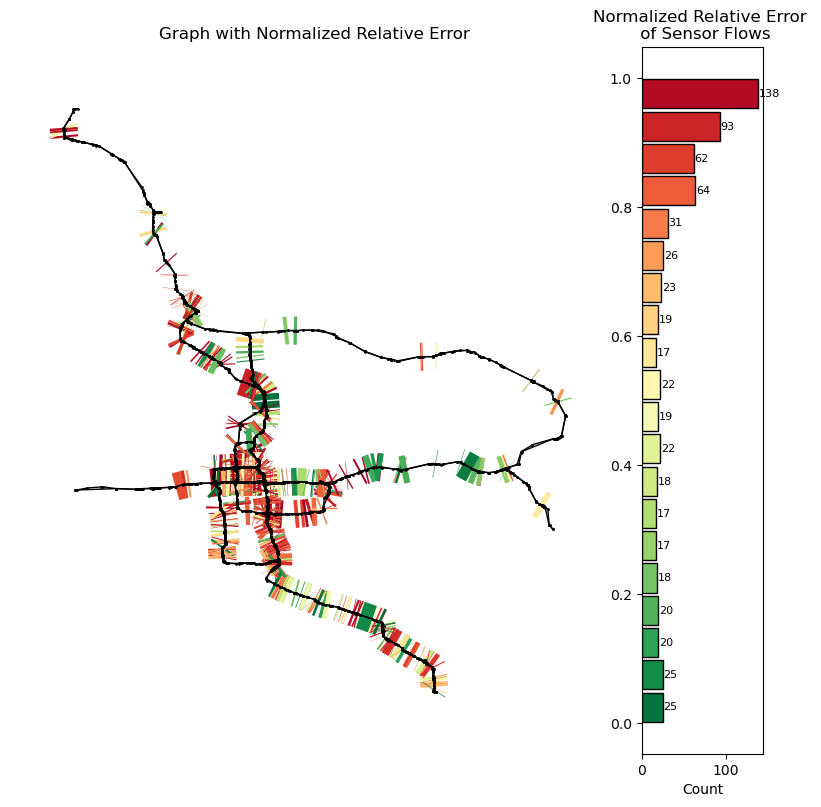

In [6]:
# Create the graph
df = pd.read_csv(Path(last_iteration_path, f"{last_iter}.countscompare.txt"), sep="\t")
G_sensor = nx.Graph()

hour_idx = 12

# Add edges with full attributes
for i in range(dataset.target_graph.num_edges):
    u, v = dataset.target_graph.edge_index[0][i].item(), dataset.target_graph.edge_index[1][i].item()
    
    if i in sensor_idxs:
        link_id = int(dataset.edge_mapping.inv[i])
        df_row = df[(df['Link Id'] == link_id) & (df['Hour'] == hour_idx)].iloc[0]
        attributes = df_row.to_dict()
        G_sensor.add_edge(u, v, **attributes)
    else:
        G_sensor.add_edge(u, v)

# Prepare plotting
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(1, 5, width_ratios=[50, -15, 1.5, 0.0, 10])  # wider graph area

ax_graph = fig.add_subplot(gs[0])  # Main graph
ax_hist = fig.add_subplot(gs[4])  # Histogram

# Get positions for nodes
pos = {i: (dataset.target_graph.pos[i][0].item(), dataset.target_graph.pos[i][1].item()) for i in range(len(dataset.target_graph.pos))}

# Separate edges
edges_with_sensor = [(u, v) for u, v in G_sensor.edges() if 'Normalized Relative Error' in G_sensor[u][v]]
edges_without_sensor = [(u, v) for u, v in G_sensor.edges() if 'Normalized Relative Error' not in G_sensor[u][v]]

# Extract weights
weights = [G_sensor[u][v]['Normalized Relative Error'] for u, v in edges_with_sensor]
print(weights)
if len(weights) == 0:
    weights = [0]

# Normalize weights
norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = plt.cm.RdYlGn.reversed()
edge_colors_sensor = [cmap(norm(weight)) for weight in weights]

# Draw graph
nx.draw_networkx_edges(G_sensor, pos, edgelist=edges_with_sensor, edge_color=edge_colors_sensor, width=20, ax=ax_graph)
nx.draw_networkx_edges(G_sensor, pos, edgelist=edges_with_sensor, edge_color='black', width=1, ax=ax_graph)
nx.draw_networkx_edges(G_sensor, pos, edgelist=edges_without_sensor, edge_color='black', width=1, ax=ax_graph)
nx.draw_networkx_nodes(G_sensor, pos, node_size=1, node_color='black', ax=ax_graph)

ax_graph.set_xlabel("X Coordinate")
ax_graph.set_ylabel("Y Coordinate")
ax_graph.set_axis_off()
ax_graph.set_title("Graph with Normalized Relative Error")

# Colorbar
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# cbar = plt.colorbar(sm, cax=ax_cbar)
# cbar.set_label("Normalized Relative Error")

# Histogram
hist_vals, bins = np.histogram(weights, bins=20)
bar_centers = (bins[:-1] + bins[1:]) / 2
bar_heights = hist_vals
bar_width = (bins[1] - bins[0]) * 0.9

# Map bin centers to colors
bin_centers = (bins[:-1] + bins[1:]) / 2  # middle of each bin
colors = [cmap(norm(center)) for center in bin_centers]

ax_hist.barh(bar_centers, bar_heights, height=bar_width, align='center', color=colors, edgecolor='black')

# Add count labels at the top of each bar
for count, center in zip(bar_heights, bar_centers):
    ax_hist.text(count + 1, center, str(count), va='center', ha='left', fontsize=8)

ax_hist.set_xlabel('Count')
ax_hist.set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.title("Normalized Relative Error \n of Sensor Flows")
plt.show()


In [5]:
def build_nre_graph(link_flows):
    # Create the graph
    df = pd.read_csv(Path(last_iteration_path, f"{last_iter}.countscompare.txt"), sep="\t")
    G_sensor = nx.Graph()

    hour_idx = 12

    # Add edges with full attributes
    for i in range(dataset.target_graph.num_edges):
        u, v = dataset.target_graph.edge_index[0][i].item(), dataset.target_graph.edge_index[1][i].item()
        
        if i in sensor_idxs:
            if isinstance(link_flows, torch.Tensor):
                target_flow = target_flows[i][hour_idx].item()
                if target_flow == 0:
                    continue
                pred_flow = link_flows[i][hour_idx].item()
                nre = abs(target_flow - pred_flow) / target_flow
                if nre > 1:
                    nre = 1
                G_sensor.add_edge(u, v, **{'Normalized Relative Error':nre})
            elif isinstance(link_flows, pd.DataFrame):
                link_id = int(dataset.edge_mapping.inv[i])
                df_row = df[(df['Link Id'] == link_id) & (df['Hour'] == hour_idx)].iloc[0]
                attributes = df_row.to_dict()
                G_sensor.add_edge(u, v, **attributes)
            else:
                raise ValueError("link_flows must be either a torch.Tensor or a pd.DataFrame")
        else:
            G_sensor.add_edge(u, v)

    # Prepare plotting
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(1, 5, width_ratios=[50, -15, 1.5, 0.0, 10])  # wider graph area

    ax_graph = fig.add_subplot(gs[0])  # Main graph
    ax_hist = fig.add_subplot(gs[4])  # Histogram

    # Get positions for nodes
    pos = {i: (dataset.target_graph.pos[i][0].item(), dataset.target_graph.pos[i][1].item()) for i in range(len(dataset.target_graph.pos))}

    # Separate edges
    edges_with_sensor = [(u, v) for u, v in G_sensor.edges() if 'Normalized Relative Error' in G_sensor[u][v]]
    edges_without_sensor = [(u, v) for u, v in G_sensor.edges() if 'Normalized Relative Error' not in G_sensor[u][v]]

    # Extract weights
    weights = [G_sensor[u][v]['Normalized Relative Error'] for u, v in edges_with_sensor]
    if len(weights) == 0:
        weights = [0]

    # Normalize weights
    norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))
    cmap = plt.cm.RdYlGn.reversed()
    edge_colors_sensor = [cmap(norm(weight)) for weight in weights]

    # Draw graph
    nx.draw_networkx_edges(G_sensor, pos, edgelist=edges_with_sensor, edge_color=edge_colors_sensor, width=20, ax=ax_graph)
    nx.draw_networkx_edges(G_sensor, pos, edgelist=edges_with_sensor, edge_color='black', width=1, ax=ax_graph)
    nx.draw_networkx_edges(G_sensor, pos, edgelist=edges_without_sensor, edge_color='black', width=1, ax=ax_graph)
    nx.draw_networkx_nodes(G_sensor, pos, node_size=1, node_color='black', ax=ax_graph)

    ax_graph.set_xlabel("X Coordinate")
    ax_graph.set_ylabel("Y Coordinate")
    ax_graph.set_axis_off()

    # Histogram
    hist_vals, bins = np.histogram(weights, bins=20)
    bar_centers = (bins[:-1] + bins[1:]) / 2
    bar_heights = hist_vals
    bar_width = (bins[1] - bins[0]) * 0.9

    # Map bin centers to colors
    bin_centers = (bins[:-1] + bins[1:]) / 2  # middle of each bin
    colors = [cmap(norm(center)) for center in bin_centers]

    ax_hist.barh(bar_centers, bar_heights, height=bar_width, align='center', color=colors, edgecolor='black')

    # Add count labels at the top of each bar
    for count, center in zip(bar_heights, bar_centers):
        ax_hist.text(count + 1, center, str(count), va='center', ha='left', fontsize=8)

    ax_hist.set_xlabel('Count')
    ax_hist.set_ylabel('')

    # Adjust layout
    plt.tight_layout()
    plt.title("Normalized Relative Error \n of Sensor Flows")
    plt.show()
